# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
# Necessary for visualization
!pip install nilearn --quiet
from nilearn import plotting, datasets

     |████████████████████████████████| 4.9 MB 8.2 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
#HCP_DIR = "/content/drive/MyDrive/NMA-CN/data/hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339
#N_SUBJECTS = 10

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [ ]:
#subjects = range(3,4)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
##fname = "hcp_rest.tgz"
##if not os.path.exists(fname):
##  !wget -qO $fname https://osf.io/bqp7m/download/
##  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

**Store the data on my drive**

In [ ]:
#!rm -r "./hcp/"

In [ ]:
#!cp -r "./hcp/" "/content/drive/MyDrive/NMA-CN/data"

**Change the value of HCP_DIR**

In [ ]:
#HCP_DIR = "/content/drive/MyDrive/NMA-CN/data/hcp"

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

**My checking**

In [ ]:
print(regions)

[['R_V1' 'R_MST' 'R_V6' ... 'L_PI' 'L_a32pr' 'L_p24']
 ['Visual1' 'Visual2' 'Visual2' ... 'Cingulo-Oper' 'Cingulo-Oper'
  'Cingulo-Oper']
 ['2.209' '2.05561' '2.1498' ... '1.74335' '1.73082' '1.65968']]


In [ ]:
print(region_info['name'])
print(len(region_info['name']))
print(region_info['network'][0:35])

['R_V1', 'R_MST', 'R_V6', 'R_V2', 'R_V3', 'R_V4', 'R_V8', 'R_4', 'R_3b', 'R_FEF', 'R_PEF', 'R_55b', 'R_V3A', 'R_RSC', 'R_POS2', 'R_V7', 'R_IPS1', 'R_FFC', 'R_V3B', 'R_LO1', 'R_LO2', 'R_PIT', 'R_MT', 'R_A1', 'R_PSL', 'R_SFL', 'R_PCV', 'R_STV', 'R_7Pm', 'R_7m', 'R_POS1', 'R_23d', 'R_v23ab', 'R_d23ab', 'R_31pv', 'R_5m', 'R_5mv', 'R_23c', 'R_5L', 'R_24dd', 'R_24dv', 'R_7AL', 'R_SCEF', 'R_6ma', 'R_7Am', 'R_7PL', 'R_7PC', 'R_LIPv', 'R_VIP', 'R_MIP', 'R_1', 'R_2', 'R_3a', 'R_6d', 'R_6mp', 'R_6v', 'R_p24pr', 'R_33pr', 'R_a24pr', 'R_p32pr', 'R_a24', 'R_d32', 'R_8BM', 'R_p32', 'R_10r', 'R_47m', 'R_8Av', 'R_8Ad', 'R_9m', 'R_8BL', 'R_9p', 'R_10d', 'R_8C', 'R_44', 'R_45', 'R_47l', 'R_a47r', 'R_6r', 'R_IFJa', 'R_IFJp', 'R_IFSp', 'R_IFSa', 'R_p9-46v', 'R_46', 'R_a9-46v', 'R_9-46d', 'R_9a', 'R_10v', 'R_a10p', 'R_10pp', 'R_11l', 'R_13l', 'R_OFC', 'R_47s', 'R_LIPd', 'R_6a', 'R_i6-8', 'R_s6-8', 'R_43', 'R_OP4', 'R_OP1', 'R_OP2-3', 'R_52', 'R_RI', 'R_PFcm', 'R_PoI2', 'R_TA2', 'R_FOP4', 'R_MI', 'R_Pir', 'R

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [ ]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

In [ ]:
print(atlas['labels_L'])
print(len(atlas['labels_L']))
print(len(atlas['labels_R']))

[233 228 220 ... 301 301 306]
10242
10242


# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

  
def selective_ts(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  condition_ts = np.concatenate(selected_data, axis=-1)

  return condition_ts

# Resting-state analyses

Load a single run of resting-state data:

In [ ]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
#timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

NameError: ignored

In [ ]:
plt.imshow(timeseries)

NameError: ignored

Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [ ]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

In [ ]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

NameError: ignored

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

In [ ]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

NameError: ignored

Threshold the correlation matrix to produce a connectome, and plot it:

In [ ]:
plotting.view_connectome(group_fc, atlas["coords"], edge_threshold="99%")

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [ ]:
#subjects = range(10)
#print(subjects)
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "emotion", concat=False))
  #timeseries_task.append(load_timeseries(subject, "motor", concat=False))

## Run a simple subtraction analysis

In [ ]:
help(load_evs)

Help on function load_evs in module __main__:

load_evs(subject, name, condition)
    Load EV (explanatory variable) data for one task condition.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of task
      condition (str) : Name of condition
    
    Returns
      evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.



In [ ]:
help(selective_average)

Help on function selective_average in module __main__:

selective_average(timeseries_data, ev, skip=0)
    Take the temporal mean across frames for a given condition.
    
    Args:
      timeseries_data (array or list of arrays): n_parcel x n_tp arrays
      ev (dict or list of dicts): Condition timing information
      skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    
    Returns:
      avg_data (1D array): Data averagted across selected image frames based
      on condition timing



In [ ]:
#subjects=range(len(subjects))

# **EMOTION TASK ANALYSIS**

## **Brain region activation**
Two approches to explore the contrast between fear and neutral condition's time series

### **Classical t-test approch**

In [ ]:
task = "EMOTION"
conditions = ["neut", "fear"]  # Run a substraction analysis between two conditions

contrast = []
results=[]
fear=[]
neut=[]
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]
  avgs=np.array(avgs)

  # Store the region-wise difference
  contrast.append(avgs[0,:] - avgs[1,:]) 
  fear.append(avgs[0,:])
  neut.append(avgs[1,:])

group_contrast = np.mean(contrast, axis=0)

t_test_p_value = []
for roi in range(360):
  # Paired T-test 
  t_test_p_value.append(stats.ttest_rel(np.array(fear)[:,roi], np.array(neut)[:,roi])[1])

#alpha_corrected = .001/360
#t_test_p_value[t_test_p_value < alpha_corrected]

x = np.sort(t_test_p_value)[0:20]
t_test_p_value_list = list(t_test_p_value)
activated_regions = [t_test_p_value_list.index(i) for i in x]
activated_regions_name = [regions[0, activated_regions[i]] for i in range(len(activated_regions))]
print(activated_regions)
print(activated_regions_name)
print([regions[1, activated_regions[i]] for i in range(len(activated_regions))])
print(group_contrast.shape)


[17, 197, 21, 201, 314, 80, 295, 20, 4, 296, 115, 140, 260, 0, 65, 138, 180, 155, 342, 78]
['R_FFC', 'L_FFC', 'R_PIT', 'L_PIT', 'L_TF', 'R_IFSp', 'L_PFt', 'R_LO2', 'R_V3', 'L_AIP', 'R_PFt', 'R_TPOJ3', 'L_IFSp', 'R_V1', 'R_47m', 'R_TPOJ1', 'L_V1', 'R_V4t', 'L_VVC', 'R_IFJa']
['Visual2', 'Visual2', 'Visual2', 'Visual2', 'Ventral-Mult', 'Default', 'Language', 'Visual2', 'Visual2', 'Language', 'Language', 'Dorsal-atten', 'Frontopariet', 'Visual1', 'Posterior-Mu', 'Default', 'Visual1', 'Visual2', 'Visual2', 'Default']
(360,)


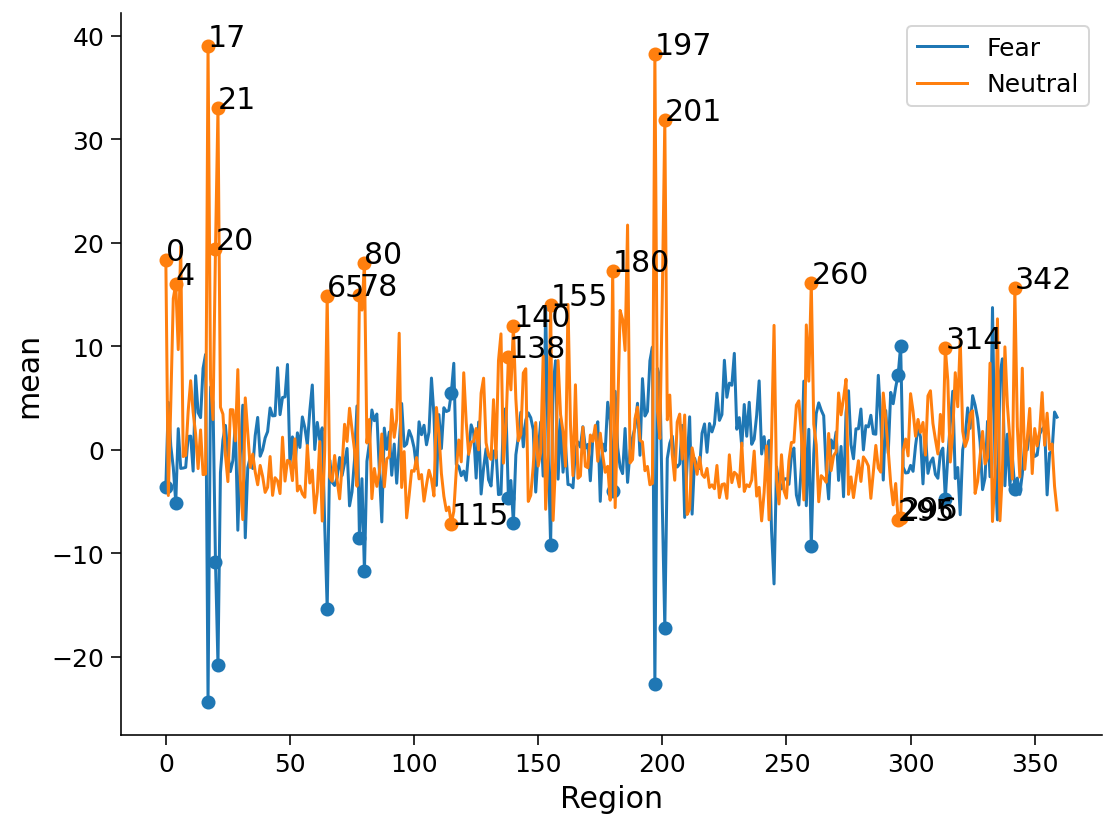

In [ ]:
fear_avg = np.mean(fear, axis = 0)
neut_avg = np.mean(neut, axis = 0)
y_fear_selected = fear_avg[activated_regions]
y_neut_selected = neut_avg[activated_regions]
xy = [(i,j) for i,j in zip(activated_regions, y_neut_selected)]
plt.plot(fear_avg, label = "Fear")
plt.plot(neut_avg, label = "Neutral")
plt.scatter(x = activated_regions, y = y_fear_selected)
plt.scatter(x = activated_regions, y = y_neut_selected)
for i in range(len(activated_regions_name)):
  plt.annotate(activated_regions[i], xy[i], )
plt.xlabel("Region")
plt.ylabel('mean')
plt.legend()
plt.show()

In [ ]:
print(activated_regions)
print(group_contrast)
group_contrast_th=np.zeros((360))

for i in range(360):
  group_contrast_th[i]=100
#print(group_contrast_th)
for i in activated_regions:
  group_contrast_th[i]=group_contrast[i]

[17, 197, 21, 201, 314, 80, 295, 20, 4, 296, 115, 140, 260, 0, 65, 138, 180, 155, 342, 78]
[-2.19798088e+01  8.99386180e+00 -4.18127570e+00 -1.63114666e+01
 -2.11164215e+01 -7.63529230e+00 -2.14236590e+01 -1.11429350e+00
 -1.15497710e+00 -2.44398147e+00 -5.35125790e+00 -5.68175511e+00
  5.64004574e+00  5.40466485e+00  1.18985906e+00  1.02605919e+01
  1.15537637e+01 -6.33070411e+01 -8.01088341e-01  1.67848336e+00
 -3.02612987e+01 -5.37244421e+01 -6.32216330e+00 -2.48482089e+00
  2.84131433e+00  2.56028737e+00 -5.98278026e+00 -4.90596189e+00
  1.71241726e+00 -1.55103953e+01  2.40839083e+00  1.10452588e+01
 -1.35100351e+01 -3.42698786e+00  9.81416909e-01 -1.39885048e+00
  3.50454801e+00  6.50355483e+00  8.88882670e-01  2.55936120e+00
  5.25957722e+00  5.37591959e+00  4.69104916e+00  7.67669168e+00
  5.99472749e+00  1.09206923e+01  7.62193193e+00  3.83309686e+00
  8.13011463e+00  9.25718598e+00 -1.97315452e-01  4.22211280e+00
 -2.72468200e+00  5.61242506e+00  3.72518700e+00  7.43234613e+00

In [ ]:
#fsaverage = datasets.fetch_surf_fsaverage()
#surf_contrast = group_contrast[atlas["labels_R"]]
#print(fsaverage)
#group_contrast = np.array([activated_regions[i] for i in range(len(activated_regions)) if i > 179])

fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast_th[atlas["labels_R"]]

plotting.view_surf(fsaverage['infl_right'],
                   surf_contrast
                   )

                  



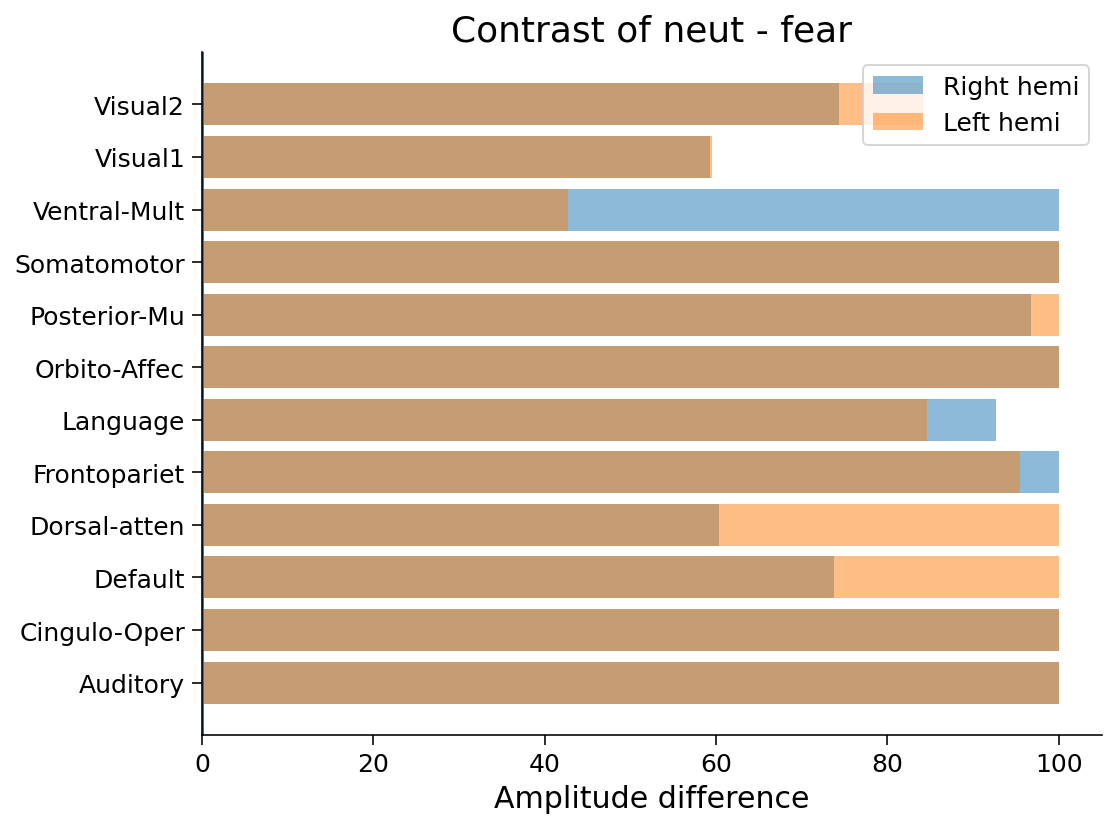

<Figure size 576x432 with 0 Axes>

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast_th, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()
plt.savefig('bar.png', bbox_inches='tight')

### **Bootstrap with a linear regression**

In [ ]:
#y_ctrt
y_ctrt = []
for i in range(len(subjects)):
  y_ctrt.extend(contrast[i])

#X
X = []
for i in range(len(subjects)):
  X.extend(range(360))

In [ ]:
X = np.array(X)
X_OHE = np.zeros((X.size, X.max()+1))
X_OHE[np.arange(X.size),X] = 1
#X_OHE

In [ ]:
X_OHE.shape

(122040, 360)

**OLS**

In [ ]:
def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  ######################################################################
  ## TODO for students: solve for the optimal parameter vector using OLS
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: solve for theta_hat vector using OLS")
  ######################################################################

  # Compute theta_hat using OLS
  theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

  return theta_hat

In [ ]:
#Model fitting
theta_hat = ordinary_least_squares(X_OHE, y_ctrt)
#theta_hat = ordinary_least_squares(x_, y_)
print(theta_hat)

[-2.19798088e+01  8.99386180e+00 -4.18127570e+00 -1.63114666e+01
 -2.11164215e+01 -7.63529230e+00 -2.14236590e+01 -1.11429350e+00
 -1.15497710e+00 -2.44398147e+00 -5.35125790e+00 -5.68175511e+00
  5.64004574e+00  5.40466485e+00  1.18985906e+00  1.02605919e+01
  1.15537637e+01 -6.33070411e+01 -8.01088341e-01  1.67848336e+00
 -3.02612987e+01 -5.37244421e+01 -6.32216330e+00 -2.48482089e+00
  2.84131433e+00  2.56028737e+00 -5.98278026e+00 -4.90596189e+00
  1.71241726e+00 -1.55103953e+01  2.40839083e+00  1.10452588e+01
 -1.35100351e+01 -3.42698786e+00  9.81416909e-01 -1.39885048e+00
  3.50454801e+00  6.50355483e+00  8.88882670e-01  2.55936120e+00
  5.25957722e+00  5.37591959e+00  4.69104916e+00  7.67669168e+00
  5.99472749e+00  1.09206923e+01  7.62193193e+00  3.83309686e+00
  8.13011463e+00  9.25718598e+00 -1.97315452e-01  4.22211280e+00
 -2.72468200e+00  5.61242506e+00  3.72518700e+00  7.43234613e+00
  6.71904664e+00  5.26903313e-02  6.99695571e+00  8.21715414e+00
  6.11762958e+00  6.75263

In [ ]:
# Compute predicted data
y_hat = X_OHE @ theta_hat

# Compute MSE
print(f"MSE = {np.mean((y_ctrt - y_hat)**2):.2f}")

MSE = 342.03


In [ ]:
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """
  #######################################################
  ## TODO for students: resample dataset with replacement
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: resample dataset with replacement")
  #######################################################

  # Get array of indices for resampled points
  sample_idx = np.random.choice(len(x), size=len(x), replace=True)
  
  # Sample from x and y according to sample_idx
  x_ = x[list(sample_idx), : ]
  y_ = np.array([y[i] for i in sample_idx])

  return x_, y_

x_, y_ = resample_with_replacement(X_OHE, y_ctrt)

In [ ]:
y_.shape

(122040,)

In [ ]:
ordinary_least_squares(x_, y_)

array([-2.29346717e+01,  8.21139928e+00, -3.90093328e+00, -1.53723485e+01,
       -2.25477372e+01, -5.04542450e+00, -2.27490330e+01, -1.82651078e+00,
       -1.43621713e+00, -1.05352889e+00, -4.61742890e+00, -5.25922070e+00,
        4.39914115e+00,  5.77353206e+00,  6.18980910e-01,  9.78180164e+00,
        1.06437964e+01, -6.36248810e+01, -3.05887485e+00,  3.54460701e+00,
       -3.24152038e+01, -5.17622509e+01, -7.44524155e+00, -1.79716886e+00,
        2.93631162e+00,  1.77919560e+00, -7.00319856e+00, -5.62227434e+00,
        3.54591303e+00, -1.47884916e+01,  3.40329894e+00,  1.02222808e+01,
       -1.25599572e+01, -4.62902234e+00,  6.06527698e-02, -1.62787700e+00,
        3.46338692e+00,  6.10365013e+00,  1.33234115e+00,  2.68963285e+00,
        5.38386968e+00,  5.67740591e+00,  2.85297749e+00,  7.72739229e+00,
        5.48557634e+00,  1.06816286e+01,  7.53290621e+00,  3.86712613e+00,
        7.87474285e+00,  9.57369933e+00,  2.93376302e-01,  4.40914527e+00,
       -2.82924956e+00,  

In [ ]:
def bootstrap_estimates(x, y, n=200):
  """Generate a set of theta_hat estimates using the bootstrap method.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute

  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)

  ##############################################################################
  ## TODO for students: implement bootstrap estimation
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: implement bootstrap estimation")
  ##############################################################################
  theta_hats = []
  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y)

    # Compute theta_hat for this sample
    #theta_hats = solve_normal_eqn(x_, y_)
    theta_hats.extend([ordinary_least_squares(x_, y_)])

  return theta_hats

In [ ]:
# Set random seed
np.random.seed(123)

# Get boostrap estimates
theta_hats = bootstrap_estimates(X_OHE, y_ctrt, n=200)

In [ ]:
m = np.mean(theta_hats, axis=0)
se = 1.96*np.std(theta_hats, axis=0)/np.sqrt(200)
lower, upper = m - se , m + se

No handles with labels found to put in legend.


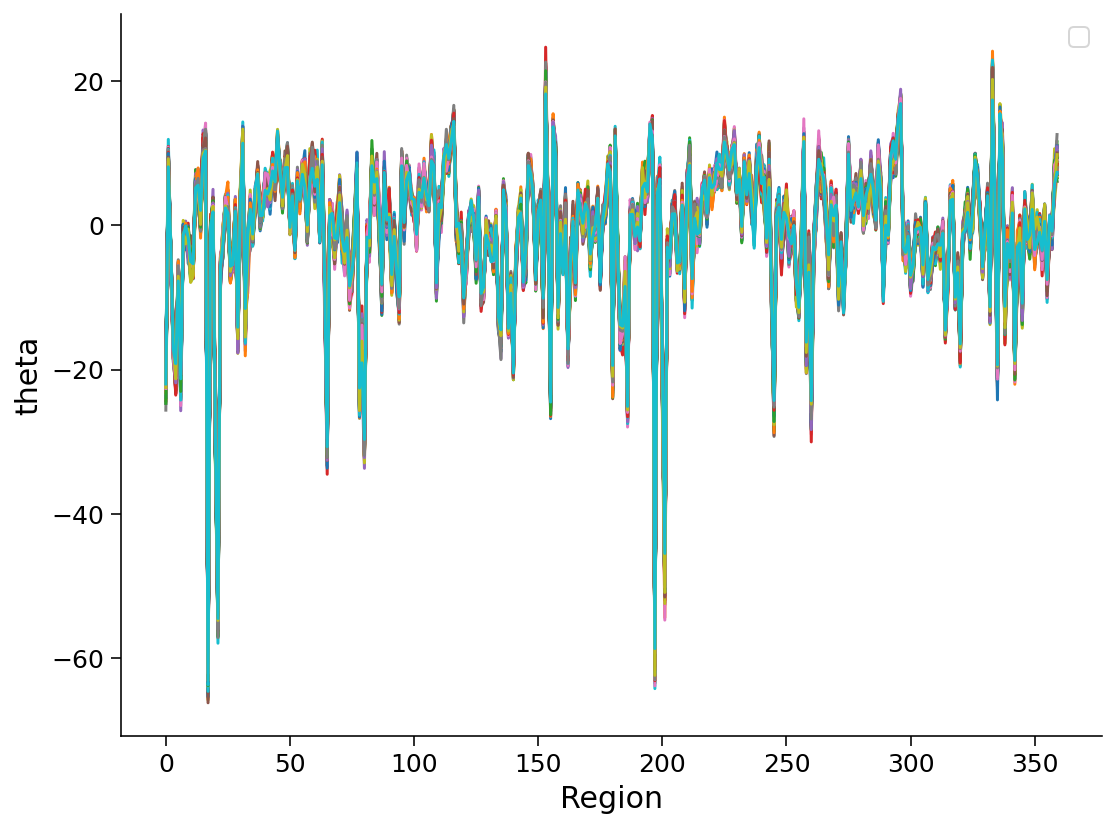

In [ ]:
#theta_boot = theta_hats

for i, theta in enumerate(theta_hats):
  plt.plot(theta)

#plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('theta')
plt.legend()
plt.show()

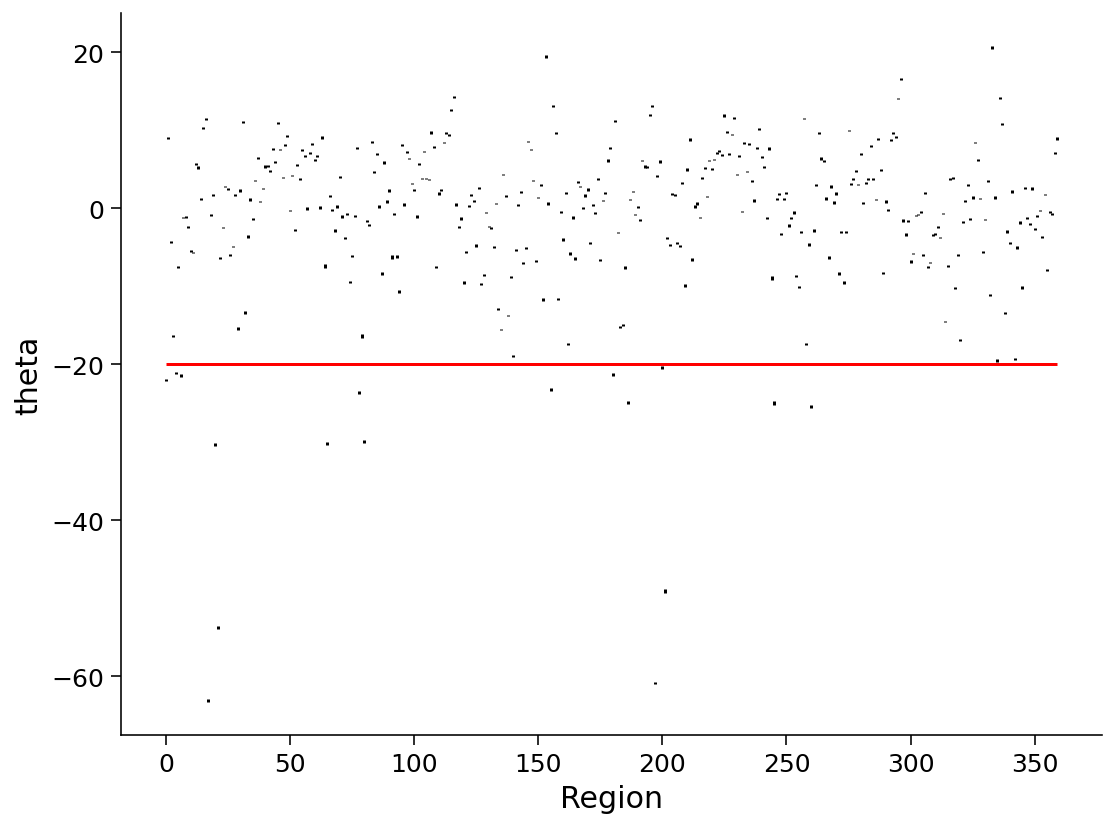

In [ ]:
plt.vlines(range(360), ymin = lower, ymax = upper,)
#plt.plot(lower, '*')
plt.hlines(-20, xmin=0, xmax=359, colors='red')

plt.xlabel("Region")
plt.ylabel('theta')
plt.show()

In [ ]:
#x = upper[upper < -20]
x = np.sort(upper)[0:20]
upper_list = list(upper)
activated_regions = [upper_list.index(i) for i in x]
#print("We have %s activated regions" % len(activated_regions) )
#print(activated_regions)
print(activated_regions)
print([regions[0, activated_regions[i]] for i in range(len(activated_regions))])
print([regions[1, activated_regions[i]] for i in range(len(activated_regions))])

[17, 197, 21, 201, 20, 65, 80, 260, 245, 186, 78, 155, 0, 6, 180, 4, 200, 335, 342, 140]
['R_FFC', 'L_FFC', 'R_PIT', 'L_PIT', 'R_LO2', 'R_47m', 'R_IFSp', 'L_IFSp', 'L_47m', 'L_V8', 'R_IFJa', 'R_V4t', 'R_V1', 'R_V8', 'L_V1', 'R_V3', 'L_LO2', 'L_V4t', 'L_VVC', 'R_TPOJ3']
['Visual2', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Posterior-Mu', 'Default', 'Frontopariet', 'Posterior-Mu', 'Visual2', 'Default', 'Visual2', 'Visual1', 'Visual2', 'Visual1', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Dorsal-atten']


## **Functionnal connectivity analysis**

In [ ]:
list_neut_ts=[]
list_fear_ts=[]
list_condition_ts = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  condition_ts = [selective_ts(timeseries_task[subject], ev) for ev in evs]
  list_neut_ts.append(condition_ts[0])
  list_fear_ts.append(condition_ts[1])
  list_condition_ts.extend(condition_ts)

In [ ]:
#list_neut_ts = [list_condition_ts[i] for i in [n for n in range(N_SUBJECTS*2) if n%2 == 0]]
#list_fear_ts = [list_condition_ts[i] for i in [n for n in range(N_SUBJECTS*2) if n%2 == 1]]

In [ ]:
fc_neut=[]
fc_neut = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(list_neut_ts):
  fc_neut[sub] = np.corrcoef(ts)

fc_fear=[]
fc_fear = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(list_fear_ts):
  fc_fear[sub] = np.corrcoef(ts)

In [ ]:
fc_neut_avg = np.mean(fc_neut, axis=0)
fc_fear_avg = np.mean(fc_fear, axis=0)
fc_neut_err = 1.96*np.std(fc_neut, axis=0)/np.sqrt(N_SUBJECTS)
fc_fear_err = 1.96*np.std(fc_fear, axis=0)/np.sqrt(N_SUBJECTS)
fc_neut_up,fc_neut_low = fc_neut_avg + fc_neut_err , fc_neut_avg - fc_neut_err
fc_fear_up, fc_fear_low = fc_fear_avg + fc_fear_err, fc_fear_avg - fc_fear_err

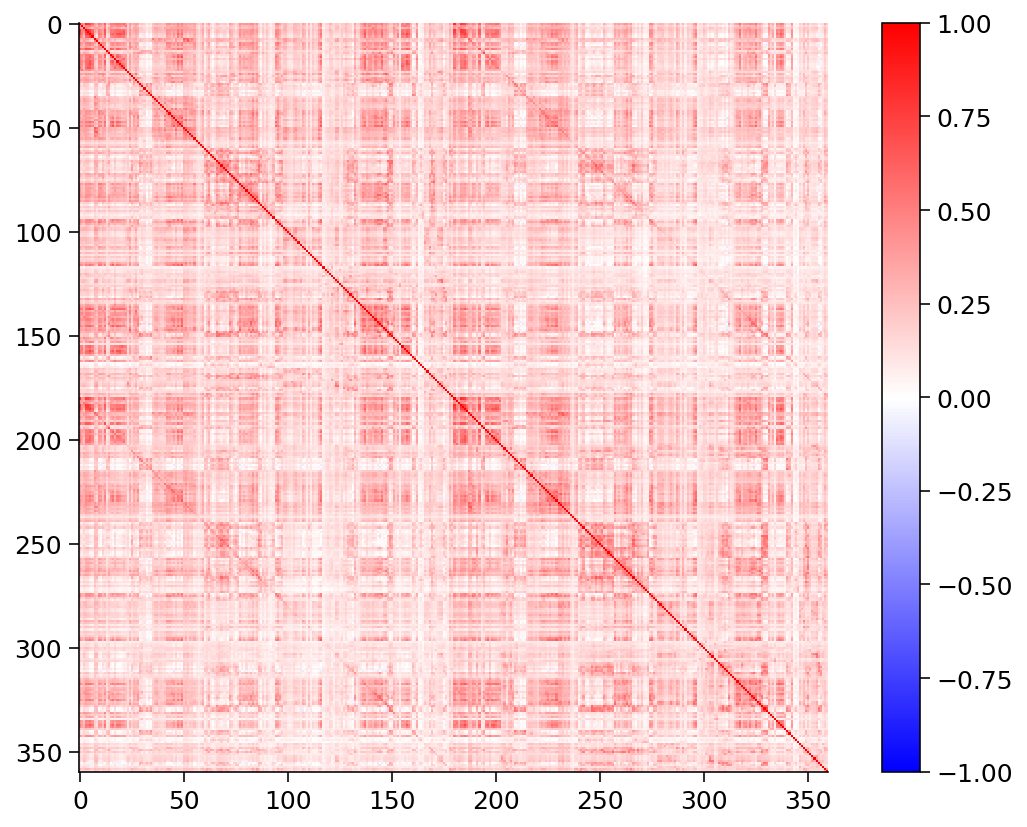

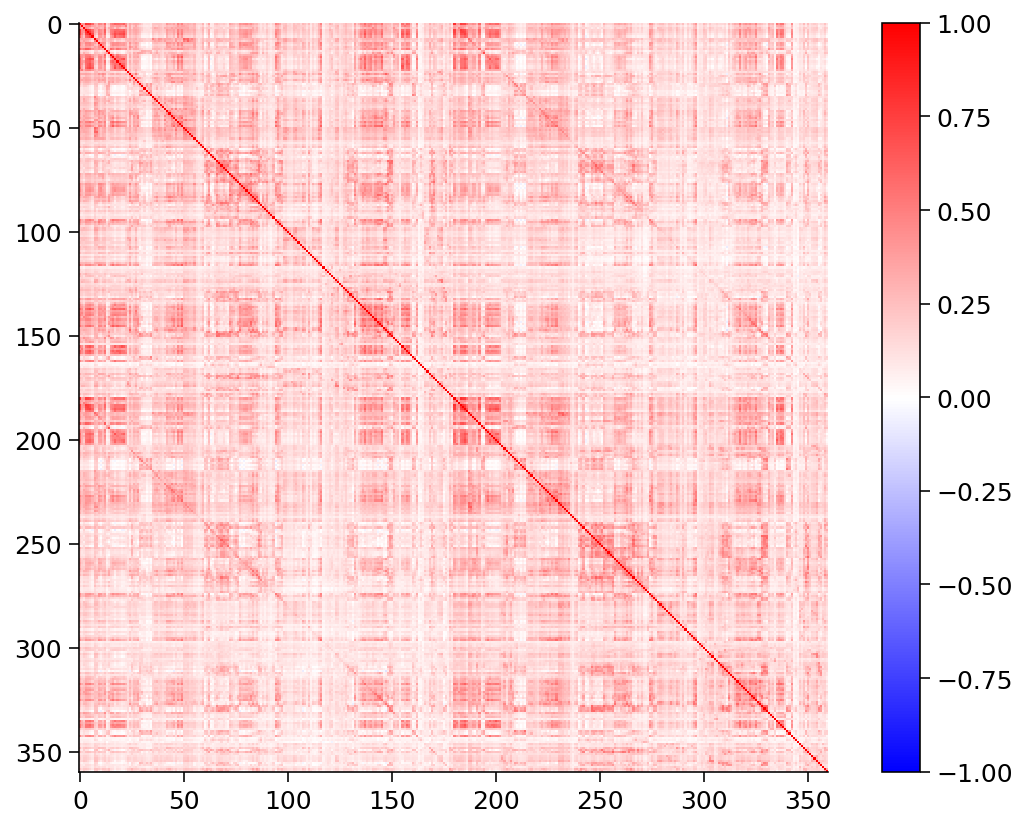

In [ ]:
plt.imshow(fc_neut_avg, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(fc_fear_avg, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
index_tri = np.triu_indices(len(fc_fear[subject]),1)
fc_neut_tri = np.array([fc_neut[subject][np.triu_indices(len(fc_neut[subject]), 1)] for subject in range(N_SUBJECTS)])
fc_fear_tri = np.array([fc_fear[subject][np.triu_indices(len(fc_fear[subject]), 1)] for subject in range(N_SUBJECTS)])

(array([ 1.,  6., 25., 29., 65., 72., 59., 49., 21., 12.]),
 array([-0.15497643, -0.05291666,  0.0491431 ,  0.15120287,  0.25326264,
         0.35532241,  0.45738218,  0.55944195,  0.66150172,  0.76356149,
         0.86562126]),
 <a list of 10 Patch objects>)

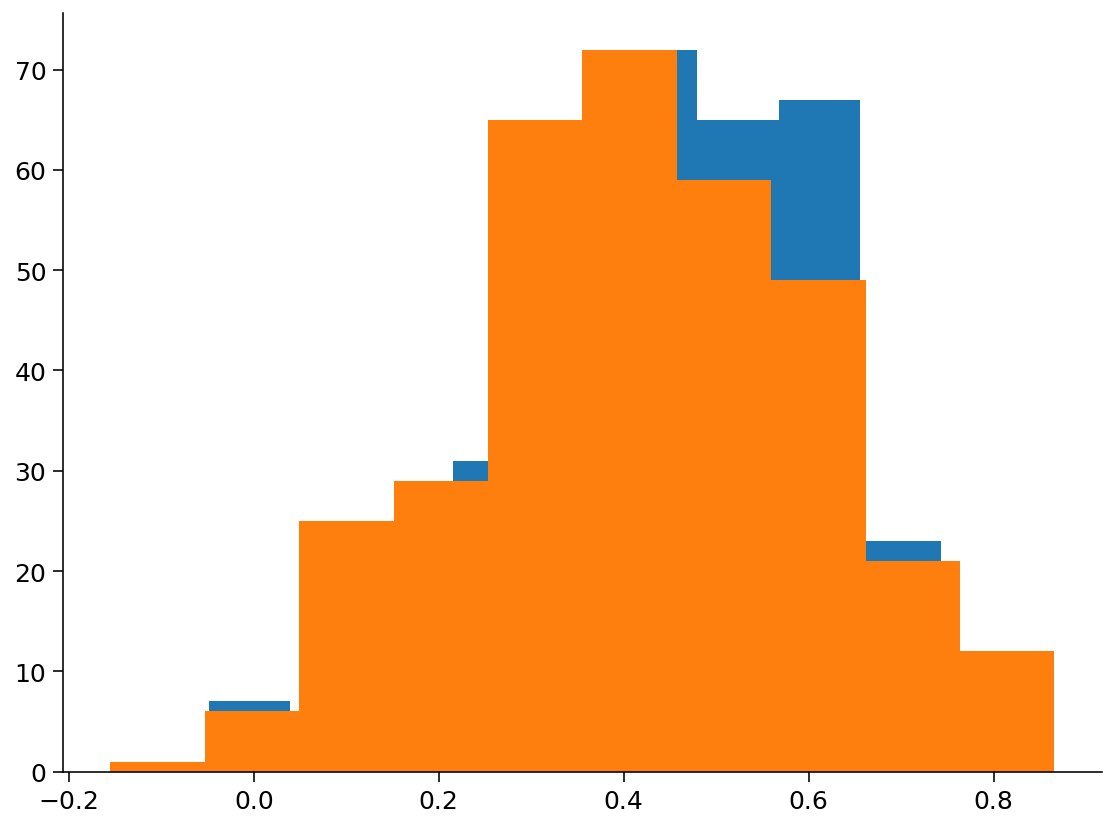

In [ ]:
plt.hist(fc_neut_tri[:, 0])
plt.hist(fc_fear_tri[:, 0])

{'boxes': [<matplotlib.lines.Line2D at 0x7f44d811ff10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f44d8179250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f44d7cb2e10>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f44d8179f50>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f44d811ff50>,
  <matplotlib.lines.Line2D at 0x7f44cfc44590>]}

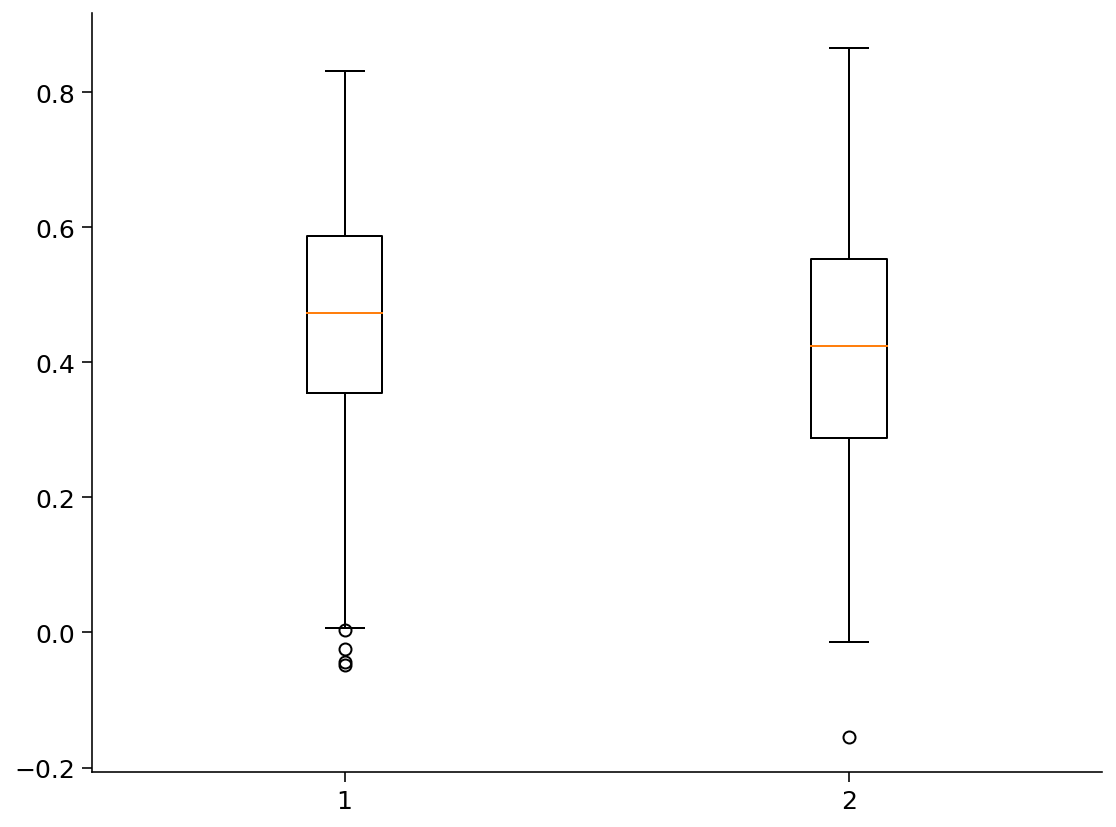

In [ ]:
plt.boxplot([fc_neut_tri[:, 0], fc_fear_tri[:, 0]])
#plt.boxplot(fc_fear_tri[:, 0])

In [ ]:
t_test_p_value = stats.ttest_rel(fc_neut_tri, fc_fear_tri, axis= 0)[1]
x = np.zeros((N_PARCELS,N_PARCELS))
x_activated_regions=np.array([0, 4, 6, 17, 20, 21, 65, 78, 80, 155, 180, 186, 197, 200, 201, 245, 260])
x[index_tri] = t_test_p_value<.001
#print (t_test_p_value.shape)
#len(t_test_p_value[t_test_p_value < .001])
#plt.imshow(x[x_activated_regions][:,x_activated_regions])

x_activated_networks= np.array(['Visual1', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Posterior-Mu', 'Default', 'Default', 'Visual2', 'Visual1', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Posterior-Mu', 'Frontopariet'])

xx_netwk = np.unique(x_activated_networks)
#print([x_activated_networks[i] for i in range(len(x_activated_networks)) if x_activated_networks == xx_netwk[0]])
grp_region = []
for xx in range(len(xx_netwk)):
  grp_region.append(x_activated_regions[x_activated_networks == xx_netwk[xx]])

#print(grp_region)
#print(xx_netwk)
print(x[index_tri])
#print(len(t_test_p_value[t_test_p_value<0.001]))
#print(np.unique(x))

[1. 1. 0. ... 0. 0. 0.]


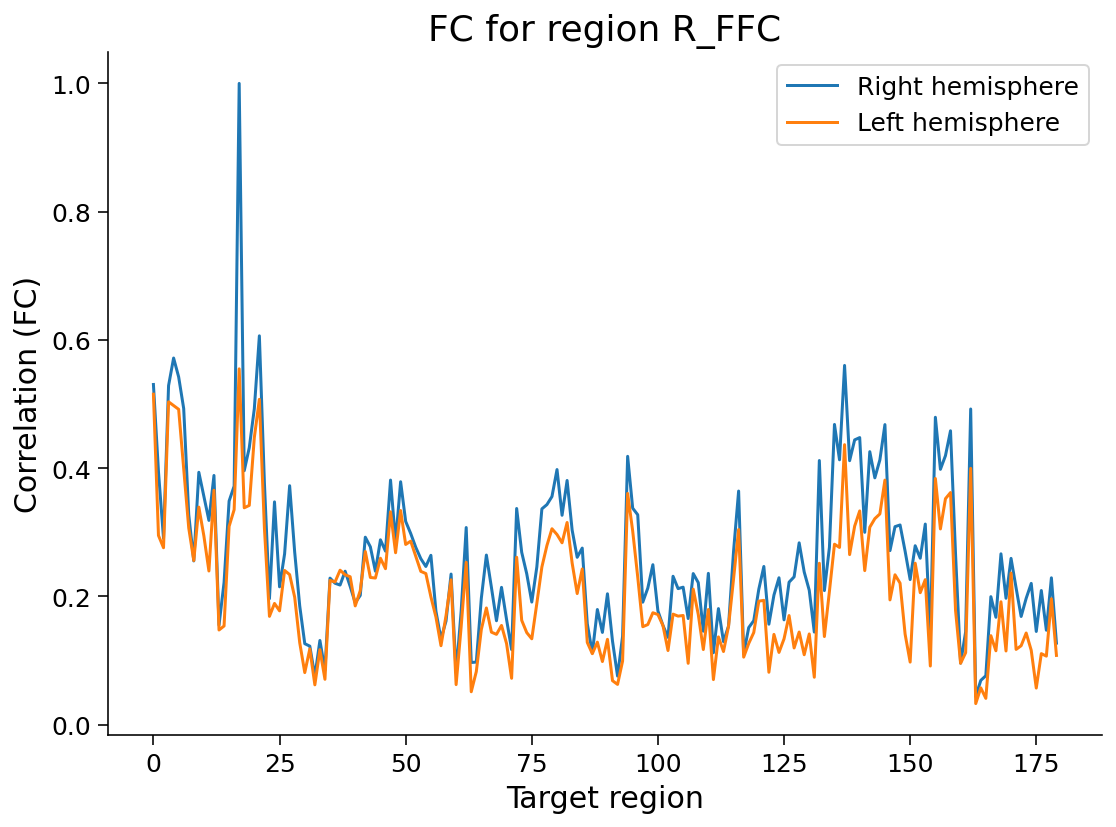

In [ ]:
seed_roi = "R_FFC"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(fc_neut_avg, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

In [ ]:
plotting.view_connectome(fc_neut_avg, atlas["coords"], edge_threshold="99.50%")

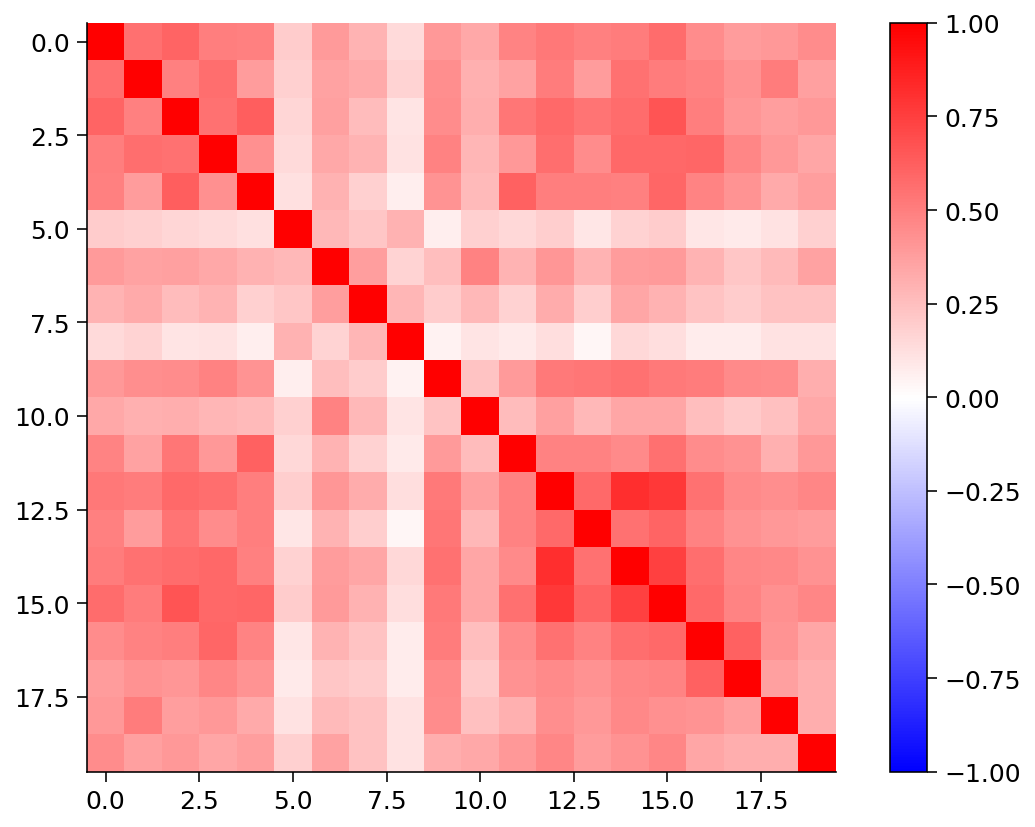

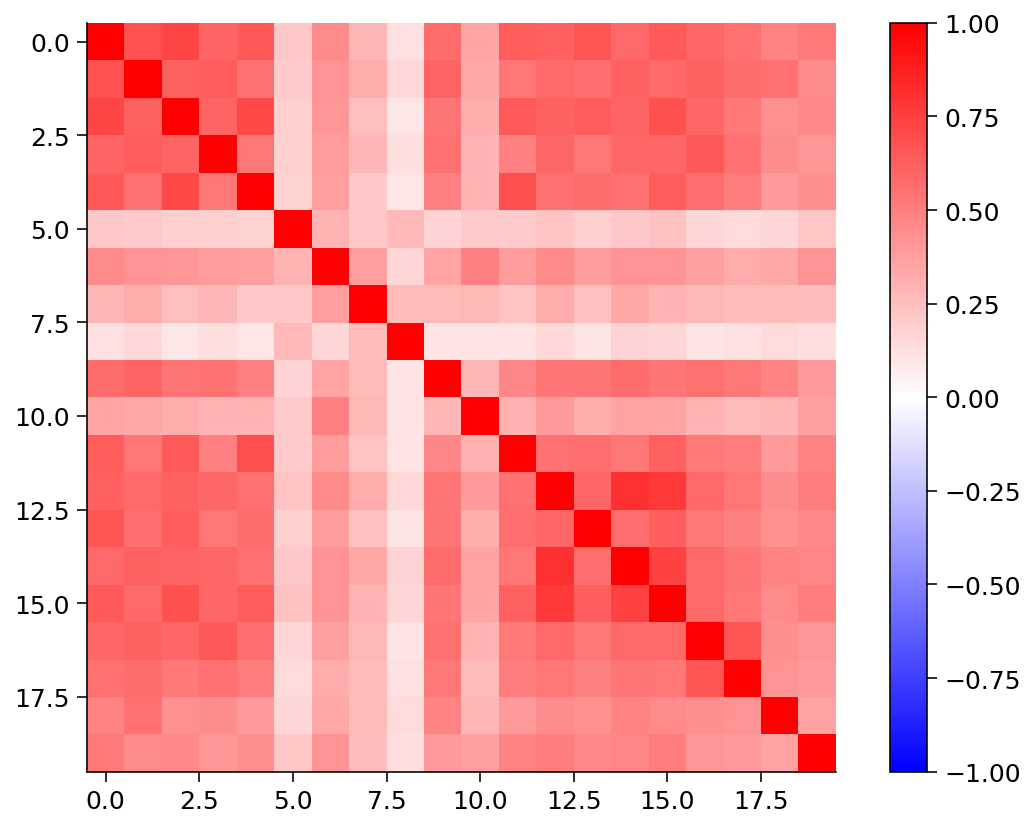

In [ ]:
fc_avg_neut = fc_neut_avg[activated_regions,:][:,activated_regions]
#fc_avg_neut = fc_neut_avg[activated_regions,:]
plt.imshow(fc_avg_neut, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()
fc_avg_fear = fc_fear_avg[activated_regions,:][:,activated_regions]
#fc_avg_fear = fc_fear_avg[activated_regions,:]
plt.imshow(fc_avg_fear, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()


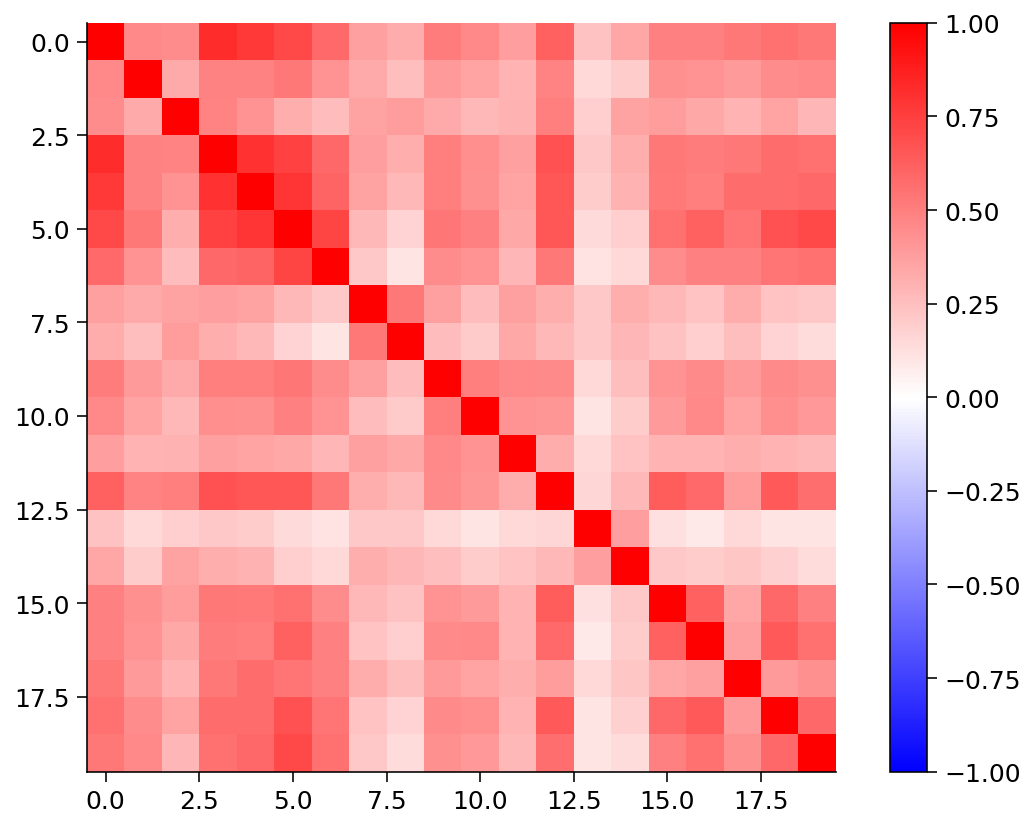

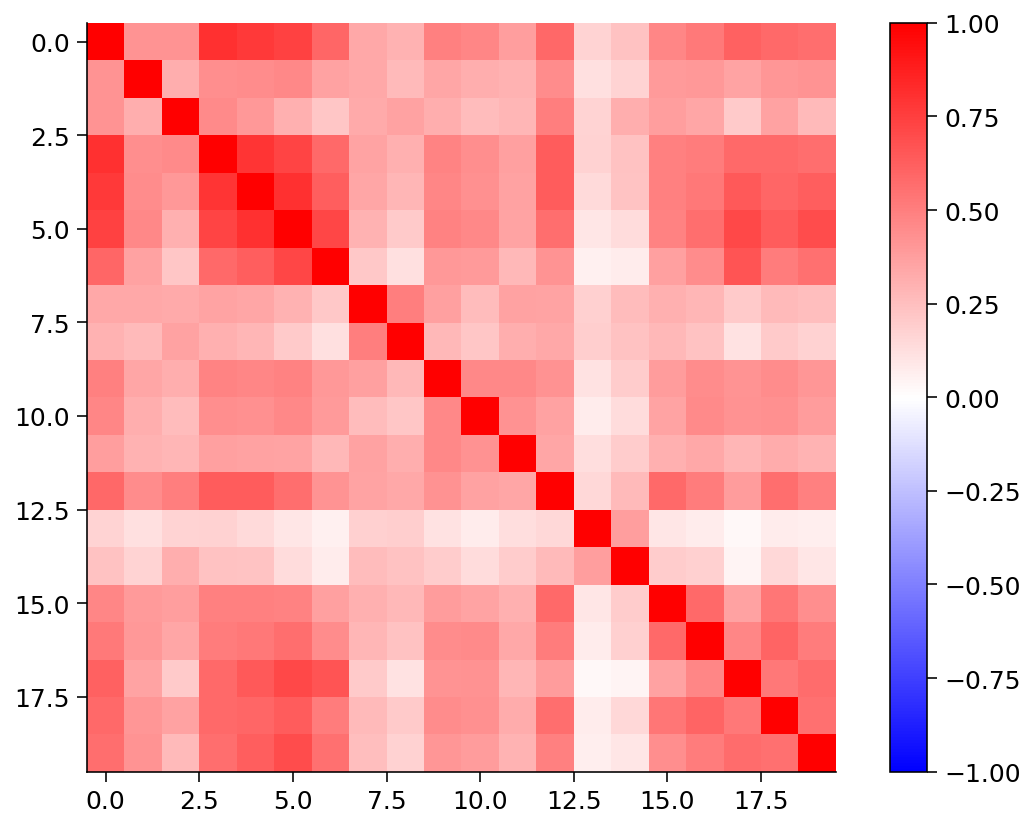

In [ ]:
fc_avg_neut = fc_neut_avg[:20,:][:,:20]
plt.imshow(fc_avg_neut, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()
fc_avg_fear = fc_fear_avg[:20,:][:,:20]
plt.imshow(fc_avg_fear, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
print(fc_fear_avg.shape)

(360, 360)


In [ ]:
a = fc_avg_fear.flatten()
b = fc_avg_neut.flatten()
np.corrcoef(a,b)[0,1]

0.977317948432923

In [ ]:
np.mean((a-b)**2)

0.002283376450932179

In [ ]:
fc_avg_neut = fc_neut_avg[activated_regions,:][:,activated_regions]

fc_avg_fear = fc_fear_avg[activated_regions,:][:,activated_regions]
a = fc_avg_fear.flatten()
b = fc_avg_neut.flatten()
np.mean((a-b)**2)


0.0045364169566024515

In [ ]:
task = "RELATIONAL"
conditions = ["match", "relation"]  # Run a substraction analysis between two conditions

contrast = []
results=[]
match=[]
relation=[]
list_match_ts=[]
list_relation_ts=[]
list_condition_ts = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  condition_ts = [selective_ts(timeseries_task[subject], ev) for ev in evs]
  list_match_ts.append(condition_ts[0])
  list_relation_ts.append(condition_ts[1])
  list_condition_ts.extend(condition_ts)

fc_match=[]
fc_match= np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(list_match_ts):
  fc_match[sub] = np.corrcoef(ts)

fc_relation=[]
fc_relation= np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(list_relation_ts):
  fc_relation[sub] = np.corrcoef(ts)

fc_match_avg = np.mean(fc_match, axis=0)
fc_relation_avg = np.mean(fc_relation, axis=0)




In [ ]:
fc_avg_match = fc_match_avg[activated_regions,:][:,activated_regions]

fc_avg_relation = fc_relation_avg[activated_regions,:][:,activated_regions]
a = fc_avg_relation.flatten()
b = fc_avg_match.flatten()
np.mean((a-b)**2)

0.001545692322576474

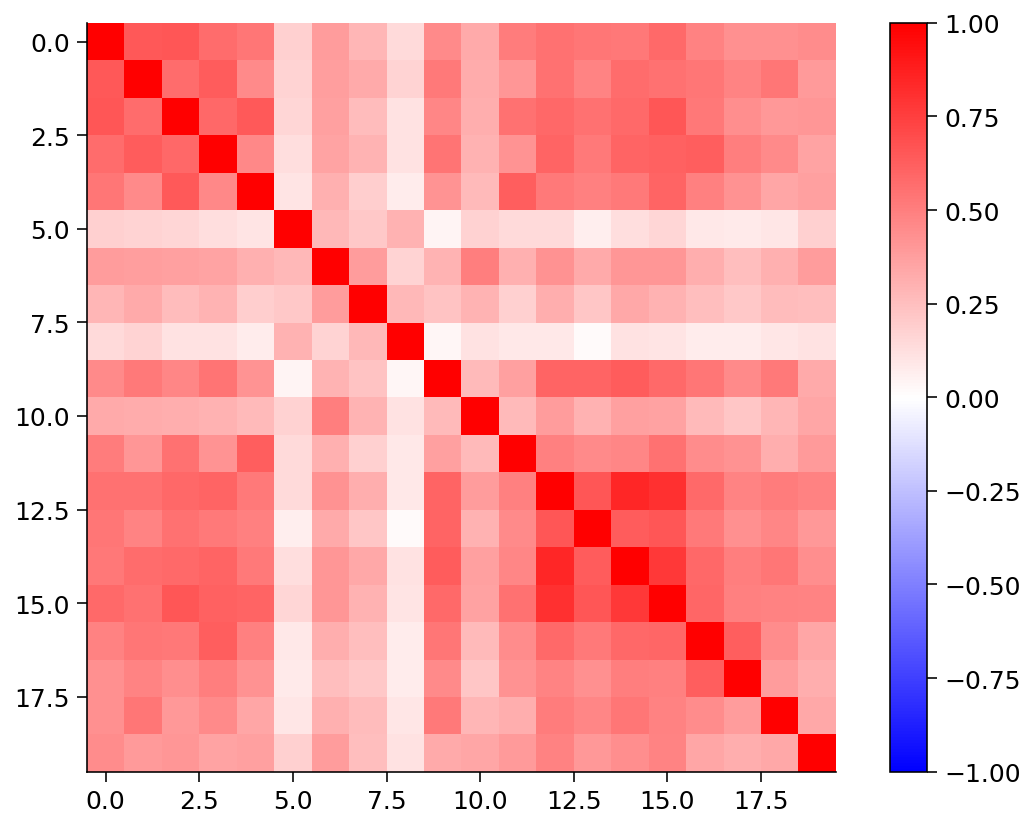

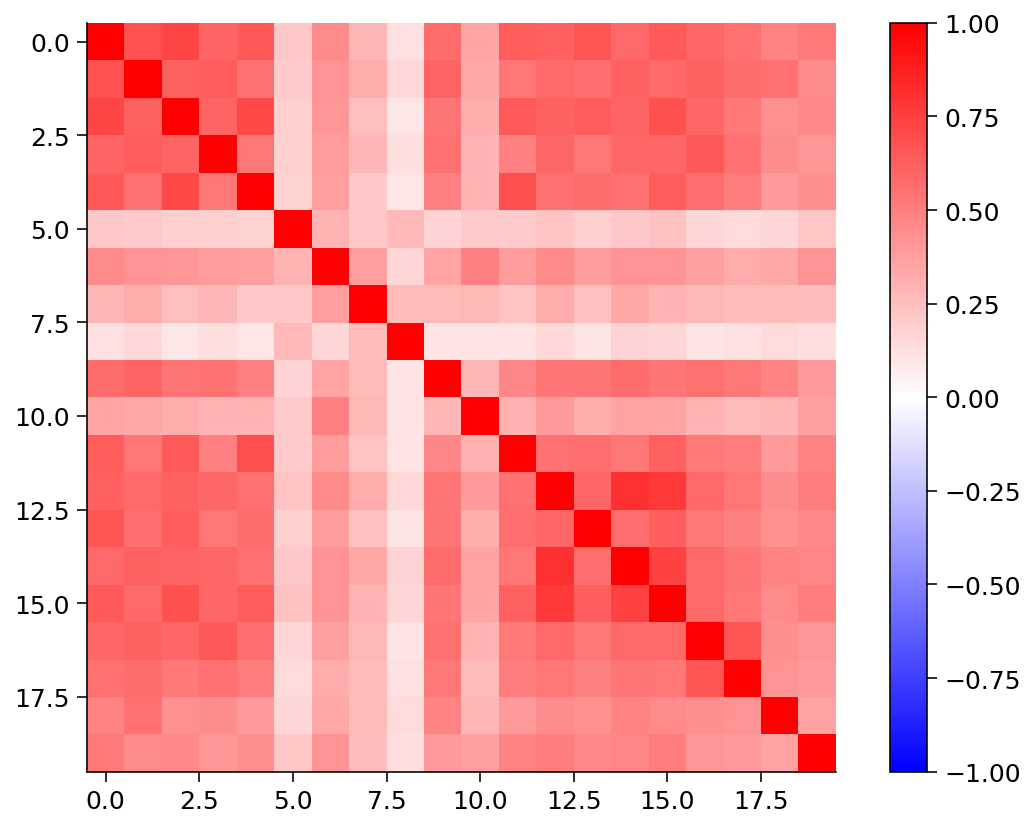

In [ ]:

#fc_avg_neut = fc_neut_avg[activated_regions,:]
plt.imshow(fc_avg_relation, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()
fc_avg_fear = fc_fear_avg[activated_regions,:][:,activated_regions]
#fc_avg_fear = fc_fear_avg[activated_regions,:]
plt.imshow(fc_avg_fear, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

**correlation matrix**

In [ ]:
timeseries_emotion = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "emotion")
  timeseries_emotion.append(ts_concat)

In [ ]:
fc=[]
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_emotion):
  fc[sub] = np.corrcoef(ts)

#group_fc = fc.mean(axis=0)

#plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
#plt.colorbar()
#plt.show()

[[1.         0.76281161 0.63687139 ... 0.24202299 0.67773756 0.35648548]
 [0.76281161 1.         0.70201996 ... 0.27981637 0.58950342 0.48648848]
 [0.63687139 0.70201996 1.         ... 0.26555893 0.43343465 0.52013316]
 ...
 [0.24202299 0.27981637 0.26555893 ... 1.         0.3115949  0.32316916]
 [0.67773756 0.58950342 0.43343465 ... 0.3115949  1.         0.4317946 ]
 [0.35648548 0.48648848 0.52013316 ... 0.32316916 0.4317946  1.        ]]


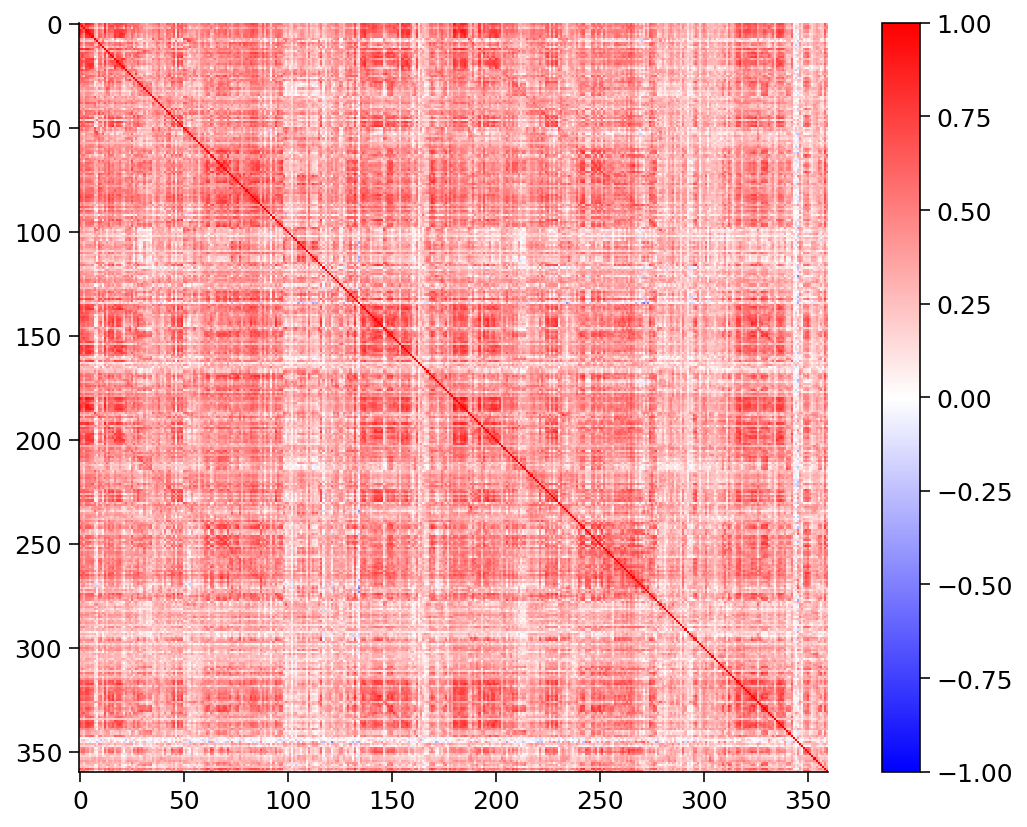

In [ ]:
print(fc[9])
plt.imshow(fc[9], interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot group-averaged contrast value across regions:

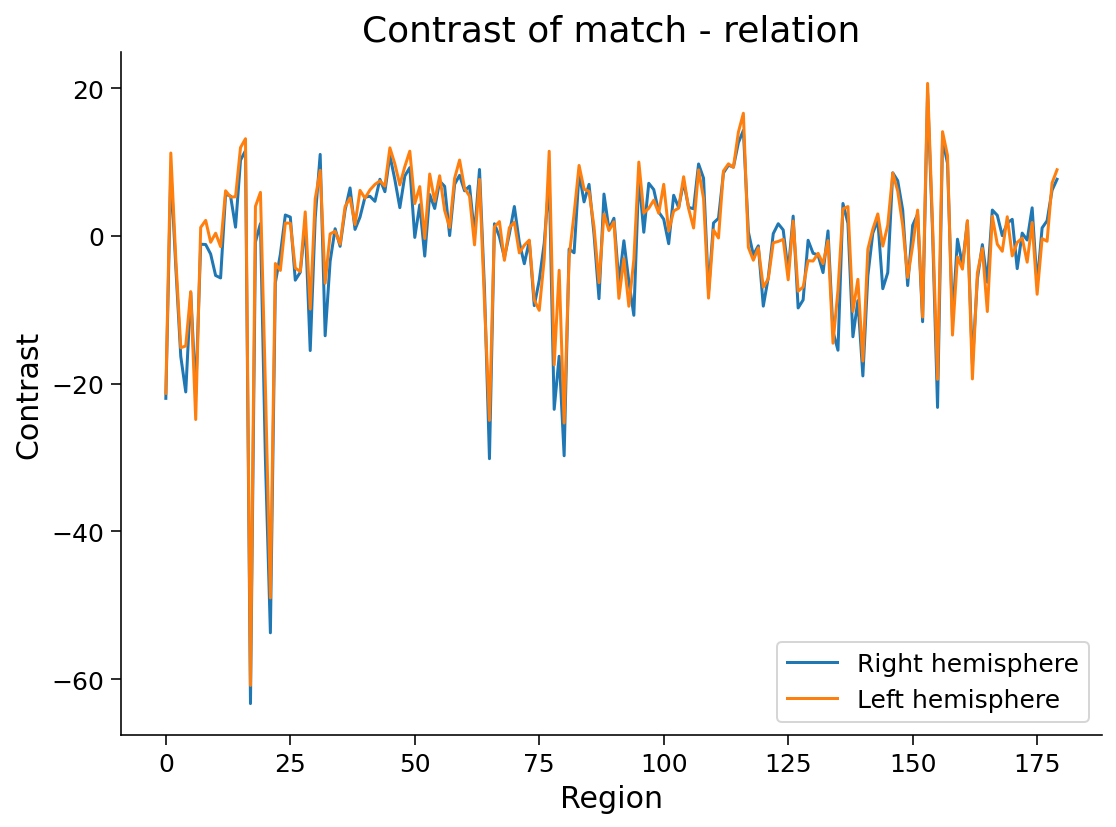

In [ ]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

In [ ]:
#x = group_contrast[group_contrast < -20]
#group_contrast_list = list(group_contrast)
#activated_regions = [group_contrast_list.index(i) for i in x]

In [ ]:
#print(activated_regions)
#print([regions[0, activated_regions[i]] for i in range(len(activated_regions))])
#print([regions[1, activated_regions[i]] for i in range(len(activated_regions))])

In [ ]:
#
timeseries_x_region = [0]*len(subjects)
for subject in subjects:
 timeseries_x_region[subject] = [timeseries_emotion[subject][activated_regions[i]] for i in range(len(activated_regions))]
#timeseries_emotion[9]
#subjects
#print(range(len(activated_regions)))
#len(timeseries_emotion[0][335])
#timeseries_emotion[0][activated_regions[0]]

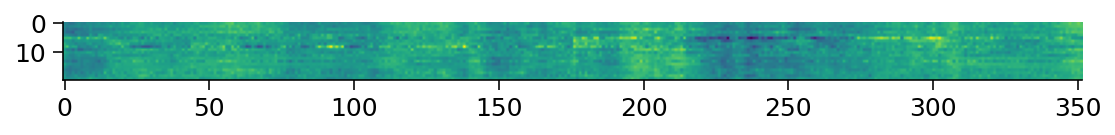

In [ ]:
plt.imshow(timeseries_x_region[0])

In [ ]:
fc_region=[]
n_parcels = 20
fc_region = np.zeros((N_SUBJECTS, n_parcels, n_parcels))
for sub, ts in enumerate(timeseries_x_region):
  fc_region[sub] = np.corrcoef(ts)

fc_avg = np.mean(fc_region, axis = 0)

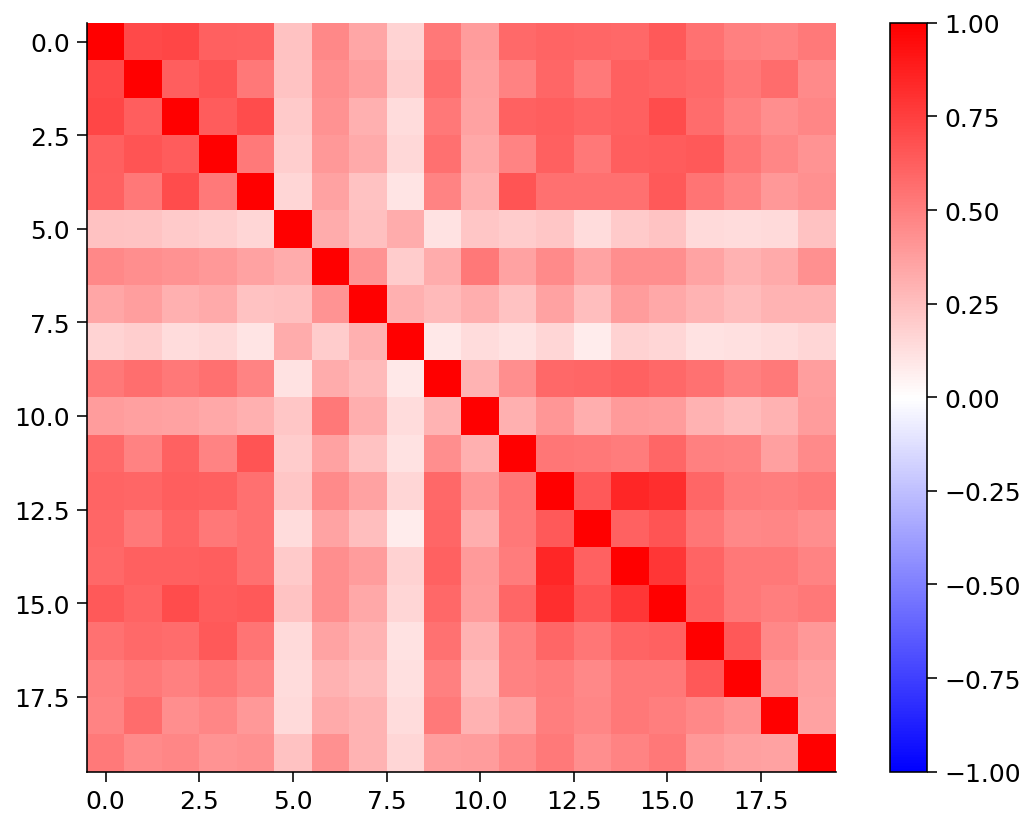

In [ ]:
#print(fc_region[9])
plt.imshow(fc_avg, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
print(group_contrast.shape)

(360,)


Plot the regional values on the surface of one hemisphere:

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=15)

NameError: ignored

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

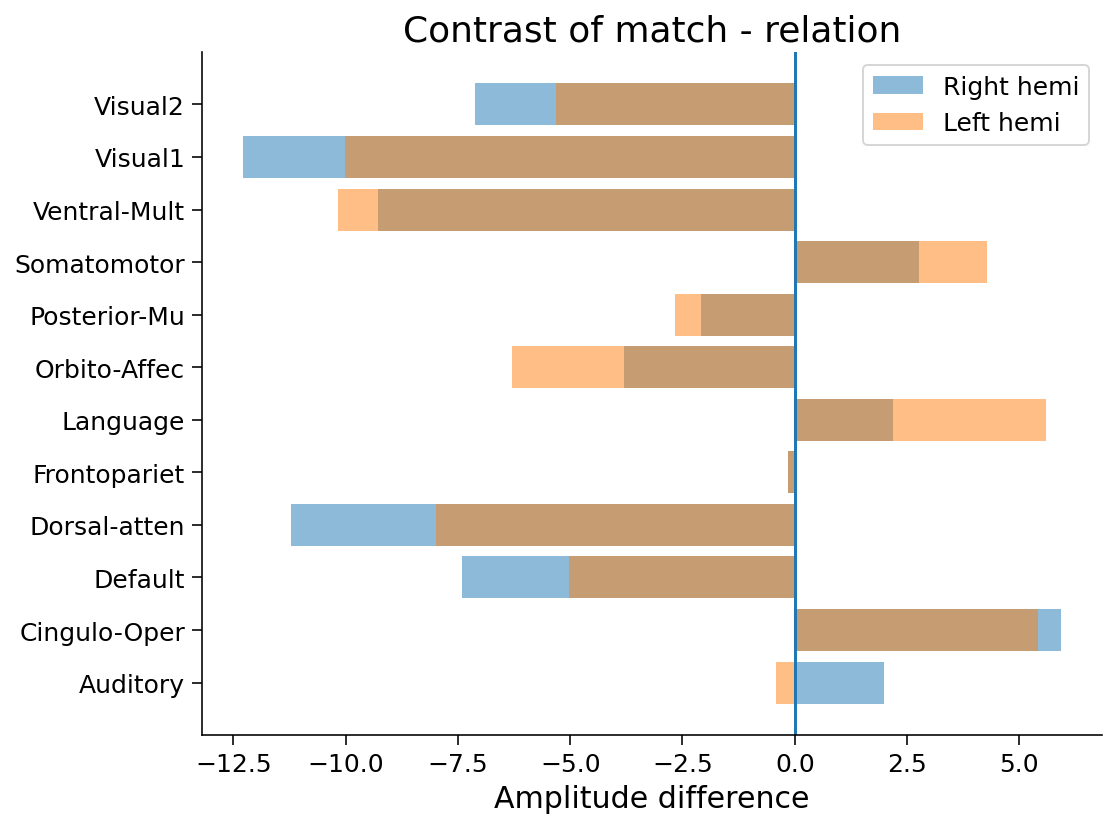

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

In [ ]:
print(network_names)

NameError: ignored

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load(f"{HCP_DIR}/pseudo_demographics.npy")
print(demo)

[[ 3.92940770e-01  5.76923145e-02 -3.65413089e-01 ... -6.24849538e-01
   1.66760668e-01 -6.30866604e-01]
 [-1.62761105e-01  9.24271835e-01  1.39939162e+00 ...  8.27661152e-02
  -1.10238897e+00 -2.31824914e+00]
 [ 9.64454601e-01 -2.06607625e-03  6.45798712e-01 ...  1.39933634e+00
   1.85177947e+00  1.60661494e+00]
 ...
 [ 1.47569763e+00 -6.27729573e-01  1.18566508e+00 ... -8.52303717e-01
  -6.58505750e-01  9.57789685e-03]
 [ 9.33300880e-02  6.92252690e-02 -3.73105779e-01 ...  1.35064854e+00
  -9.85437060e-01 -1.88730730e-02]
 [-1.24787589e+00  7.14649189e-03 -2.03767407e+00 ... -1.87849042e-01
  -1.83167242e+00  4.95479179e-02]]


## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]


In [ ]:
#y_ctrt
y_ctrt = []
for i in range(len(subjects)):
  y_ctrt.extend(contrast[i])

y = np.array(np.zeros_like(y_ctrt))
for i in range(len(y)):
  if y_ctrt[i] < 0:
    y[i] = 1

#X
X = []
for i in range(len(subjects)):
  X.extend(range(360))

X = np.array(X)
X_OHE = np.zeros((X.size, X.max()+1))
X_OHE[np.arange(X.size),X] = 1
#X_OHE

IndexError: ignored